# Подготовка данных
Необходимо создать excel или использовать готовую таблицу с некоторыми тестовыми данными

In [359]:
import pandas as pd
import math
import time
import torch
import torch.nn.functional as F
import numpy as np
import cupy as cp
from torch import Tensor
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

df = pd.read_excel("tests6.xlsx")
#df = pd.read_excel("tests_md.xlsx")
#df = pd.read_excel("tests_lg.xlsx")
df.head()

,Id,Direction,Section,TestCaseName,Automated,Preconditions,Steps,Postconditions,ExpectedResult,TestData,Comments,Iterations,Priority,State,CreatedDate,CreatedById,Tags
0,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Highest,Ready,05/23/2024 14:48:49,Служебный пользователь для Автотестов,смоук хф
1,NaN,NaN,NaN,NaN,NaN,"Роль:\n\n\nОперационист ТП, Контролер",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,Выполнен вход в ЕФР под ролью Контролер,NaN,NaN,Открывается страница поиска клиента,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,Предварительно инициировать/найти операцию доступную для исполнения в роли контролера(например перевод клиенту Банка со счета),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,"Кликнуть на раздел ""Задачи"" в верхней части экрана",NaN,"На странице задач отображается список задач(по умолчанию выделен раздел ""Доступные задачи"") доступных на исполнение пользователю.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [360]:
if torch.cuda.is_available():
    torch.cuda.get_device_properties('cuda')
else:
    pass

In [361]:
# Переключаем PyTorch на использование GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Начало обработки

Удаляем ненужные столбцы, заполняем нужные ячейки дублирующими значениями

In [362]:
start_timer = time.time()

def clean_dataset(dataset: pd.DataFrame) -> pd.DataFrame: 
    output_dataset = dataset[["Id", "Direction", "Section", "TestCaseName", "Preconditions", "Steps", "Postconditions", "ExpectedResult"]].copy()
    output_dataset[["Id", "Direction", "Section", "TestCaseName"]] = output_dataset[["Id", "Direction", "Section", "TestCaseName"]].ffill()
    return output_dataset

output = clean_dataset(df)
end_timer = time.time()

print(end_timer - start_timer)
output.to_excel("output.xlsx", index = False)
output.head()

0.0019996166229248047


,Id,Direction,Section,TestCaseName,Preconditions,Steps,Postconditions,ExpectedResult
0,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,NaN,NaN,NaN
1,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Роль:\n\n\nОперационист ТП, Контролер",NaN,NaN,NaN
2,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Выполнен вход в ЕФР под ролью Контролер,NaN,NaN,Открывается страница поиска клиента
3,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Предварительно инициировать/найти операцию доступную для исполнения в роли контролера(например перевод клиенту Банка со счета),NaN,NaN,NaN
4,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,"Кликнуть на раздел ""Задачи"" в верхней части экрана",NaN,"На странице задач отображается список задач(по умолчанию выделен раздел ""Доступные задачи"") доступных на исполнение пользователю."


# Разбиваем тест-кейсы на отдельные DataFrame

На выходе получим массив датафреймов(тест-кейсов)

In [363]:
start_timer = time.time()

def parse_tests_by_id(dataset: pd.DataFrame) -> List[pd.DataFrame]:
    test_cases = []
    for group_name, frame in dataset.groupby('Id'):
        test_cases.append(frame)

    return test_cases

output_array = parse_tests_by_id(output)
end_timer = time.time()
print(end_timer - start_timer)
output_array[0]

0.0010006427764892578


,Id,Direction,Section,TestCaseName,Preconditions,Steps,Postconditions,ExpectedResult
0,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,NaN,NaN,NaN
1,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Роль:\n\n\nОперационист ТП, Контролер",NaN,NaN,NaN
2,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Выполнен вход в ЕФР под ролью Контролер,NaN,NaN,Открывается страница поиска клиента
3,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Предварительно инициировать/найти операцию доступную для исполнения в роли контролера(например перевод клиенту Банка со счета),NaN,NaN,NaN
4,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,"Кликнуть на раздел ""Задачи"" в верхней части экрана",NaN,"На странице задач отображается список задач(по умолчанию выделен раздел ""Доступные задачи"") доступных на исполнение пользователю."
5,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,"Нажать ""Взять"" для задачи из пула текущего пользователя",NaN,"Задаче назначается исполнитель – текущий пользователь и список задач обновляется (задача пропадает из пула ""Доступные задачи"") Задачу можно увидеть в разделе ""Мои задачи"""
6,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,"Кликнуть ""Мои задачи""",NaN,"Открывается пул задач, доступных на исполнение"
7,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,"Нажать ""Исполнить"" для задачи из пула текущего пользователя",NaN,Открывается форма задачи в текущей вкладке


In [364]:
output_array[1]

,Id,Direction,Section,TestCaseName,Preconditions,Steps,Postconditions,ExpectedResult
8,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,NaN,NaN,NaN,NaN
9,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,Роль:\n\n\nОперационист ТП,NaN,NaN,NaN
10,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,Выполнен вход в ЕФР,NaN,NaN,Открывается страница поиска клиента
11,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,NaN,"Кликнуть ""Задачи"" в верхней части экрана",NaN,На форме отображается список задач доступных на исполнение пользователю.
12,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,NaN,"Нажать ""Взять и исполнить"" для задачи из пула текущего пользователя",NaN,открывается форма задачи


In [365]:
#output_array[2]

# Удаление пустых ячеек

In [366]:
start_timer = time.time()

def remove_empty_cells(array):
    # обрабатываем "Preconditions", "Steps", "Postconditions", "ExpectedResult" (удаляем первую ячейку)
    def up_cells(tst_case, column):
        for i in range(len(tst_case[column])):
            if i == len(tst_case.index) - 1:
                tst_case.at[tst_case.index[i], column] = math.nan
                break
            else:
                tst_case.at[tst_case.index[i], column] = tst_case.at[tst_case.index[i + 1], column]
                
        return tst_case
        
    for dframe in array:
        for col in ["Preconditions", "Steps", "Postconditions", "ExpectedResult"]:
            dframe = up_cells(dframe, col)
              
        dframe["Steps"] = dframe["Steps"].fillna(dframe["Preconditions"])
        dframe["Steps"] = dframe["Steps"].fillna(dframe["Postconditions"])
        dframe.drop(["Preconditions", "Postconditions"], inplace=True, axis=1)     
            
    return array

edited_output_array = remove_empty_cells(output_array)
end_timer = time.time()
print(end_timer - start_timer)
edited_output_array[0]

0.010003089904785156


,Id,Direction,Section,TestCaseName,Steps,ExpectedResult
0,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Роль:\n\n\nОперационист ТП, Контролер",NaN
1,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Выполнен вход в ЕФР под ролью Контролер,Открывается страница поиска клиента
2,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,Предварительно инициировать/найти операцию доступную для исполнения в роли контролера(например перевод клиенту Банка со счета),NaN
3,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Кликнуть на раздел ""Задачи"" в верхней части экрана","На странице задач отображается список задач(по умолчанию выделен раздел ""Доступные задачи"") доступных на исполнение пользователю."
4,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Нажать ""Взять"" для задачи из пула текущего пользователя","Задаче назначается исполнитель – текущий пользователь и список задач обновляется (задача пропадает из пула ""Доступные задачи"") Задачу можно увидеть в разделе ""Мои задачи"""
5,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Кликнуть ""Мои задачи""","Открывается пул задач, доступных на исполнение"
6,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,"Нажать ""Исполнить"" для задачи из пула текущего пользователя",Открывается форма задачи в текущей вкладке
7,544031.0,AI_Отладка,Пул задач пользователя,Контролер. Исполнить задачу,NaN,NaN


In [367]:
pd.DataFrame(pd.concat(edited_output_array)).to_excel("edited_output.xlsx", index=False)

In [368]:
edited_output_array[1]

,Id,Direction,Section,TestCaseName,Steps,ExpectedResult
8,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,Роль:\n\n\nОперационист ТП,NaN
9,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,Выполнен вход в ЕФР,Открывается страница поиска клиента
10,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,"Кликнуть ""Задачи"" в верхней части экрана",На форме отображается список задач доступных на исполнение пользователю.
11,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,"Нажать ""Взять и исполнить"" для задачи из пула текущего пользователя",открывается форма задачи
12,544032.0,AI_Отладка,Пул задач пользователя,Контролер. Взять и исполнить задачу,NaN,NaN


# (Опционально) Замена тест-кейсов в массиве на наборы текстовых предложений

In [369]:
# Предложения для теста

# Во время обучения модели machine learning, важно обеспечить достаточное количество данных для тренировки
# Использование API позволяет интегрировать различные сервисы в ваше приложение, упрощая процесс разработки
# Для анализа больших объемов данных рекомендуется использовать фреймворк Hadoop, который обеспечивает эффективную обработку данных
# В процессе дебаггинга программы была обнаружена ошибка, связанная с неправильным использованием переменных
# При разработке user interface необходимо учитывать принципы user experience, чтобы сделать приложение максимально удобным для пользователя

def switch_to_lang(array):
    array.clear()
    array.append("Во время обучения модели machine learning, важно обеспечить достаточное количество данных для тренировки") 
    array.append("Во время обучения модели машинного обучения, важно обеспечить достаточное количество данных для тренировки") 
    array.append("Использование API позволяет интегрировать различные сервисы в ваше приложение, упрощая процесс разработки") 
    array.append("The use of an API allows you to integrate various services into your application, simplifying the development process")
    array.append("Для анализа больших объемов данных рекомендуется использовать фреймворк Hadoop, который обеспечивает эффективную обработку данных") 
    array.append("В процессе дебаггинга программы была обнаружена ошибка, связанная с неправильным использованием переменных") 
    array.append("При разработке user interface необходимо учитывать принципы user experience, чтобы сделать приложение максимально удобным для пользователя") 
    array.append("При разработке пользовательского интерфейса необходимо учитывать принципы пользовательского опыта, чтобы сделать приложение максимально удобным для пользователя") 
    return array

edited_output_array = switch_to_lang(edited_output_array)

len(edited_output_array)

8

# spaCy

```conda install spacy```

```python -m spacy download ru_core_news_lg```


In [370]:
import spacy

# Переключаем spaCy на использование GPU, если доступно
spacy.prefer_gpu()
# spacy.require_gpu()

start_timer = time.time()

spacy_nlp = spacy.load("ru_core_news_lg")

def vectorize_text(text: str, spacy_model: spacy.Language) -> torch.Tensor:
    doc = spacy_model(text)
    if type(doc.vector) is cp.ndarray:
        return torch.from_numpy(cp.asnumpy(doc.vector).reshape(1, -1))
    else:
        return torch.from_numpy(doc.vector.reshape(1, -1))
    

spacy_vectorized_output_array = []

for test_case in edited_output_array:
    spacy_vectorized_output_array.append(F.normalize(vectorize_text(str(test_case), spacy_nlp), p=2, dim=1))

def output_spacy_to_csv():
    for i in range(len(spacy_vectorized_output_array)):
        pd.DataFrame(spacy_vectorized_output_array[i]).to_csv("spacy_output/spacy_vectorized_output_" + str(i) + ".csv", index = False)    

output_spacy_to_csv()

end_timer = time.time()
print(end_timer - start_timer)
spacy_vectorized_output_array[0]

1.3157005310058594


tensor([[ 0.0471, -0.0748, -0.0610, -0.0308, -0.0149,  0.0886,  0.0870,  0.0077,
          0.0700,  0.0339, -0.0472, -0.0431,  0.0008,  0.0545,  0.0112,  0.0404,
          0.0015, -0.1282,  0.0390,  0.0980, -0.0058, -0.0605,  0.0373,  0.0203,
         -0.0277, -0.0349, -0.1218,  0.1113,  0.0032,  0.0061, -0.0275, -0.0371,
          0.1314,  0.0807,  0.0299, -0.0705, -0.0662,  0.0014,  0.0802, -0.0215,
          0.0934,  0.0025, -0.0044, -0.0394,  0.0728, -0.0668, -0.0305, -0.0232,
         -0.0201,  0.0019, -0.0691, -0.0614, -0.0398,  0.0151,  0.0022, -0.0206,
         -0.0657, -0.0779, -0.1019, -0.0209,  0.0585, -0.0947, -0.0818,  0.0135,
          0.0216, -0.0593,  0.0538, -0.0057, -0.0232,  0.0206, -0.0246,  0.0273,
         -0.0147,  0.0961, -0.0236,  0.0589, -0.0263, -0.0329,  0.0204,  0.0419,
         -0.1075,  0.0207, -0.0790,  0.0457,  0.0399, -0.0403, -0.1879, -0.0219,
          0.0126,  0.0399,  0.0363,  0.0232, -0.0409, -0.0646, -0.0837, -0.0008,
         -0.0438, -0.0362, -

# sentence-transformers/paraphrase-multilingual-mpnet-base-v2

```conda install -c conda-forge sentence-transformers```

https://huggingface.co/sentence-transformers/paraphrase-multilingual-mpnet-base-v2

In [371]:
from transformers import AutoTokenizer, AutoModel

start_timer = time.time()

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]  # First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
mpnet_vectorized_output_array = []

model.to(device)

for test_case in edited_output_array:
    # Tokenize
    encoded_input = tokenizer(str(test_case), return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling. In this case, average pooling
    embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    mpnet_vectorized_output_array.append(F.normalize(embedding, p=2, dim=1))

def output_mpnet_to_csv():
    for i in range(len(mpnet_vectorized_output_array)):
        pd.DataFrame(mpnet_vectorized_output_array[i].cpu()).to_csv("mpnet_output/mpnet_vectorized_output_" + str(i) + ".csv", index = False)

output_mpnet_to_csv()

end_timer = time.time()
print(end_timer - start_timer)
mpnet_vectorized_output_array

C:\Users\paul\.conda\envs\EmbeddingTest\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


1.682647705078125


[tensor([[-2.0966e-02,  5.6801e-02, -7.5774e-04,  3.3114e-03,  2.8386e-02,
          -7.6483e-03,  2.4845e-02,  4.2891e-03, -3.1278e-02, -7.2320e-04,
           3.8285e-02,  2.9568e-02, -2.4418e-02,  8.3024e-02,  3.1466e-02,
          -6.4941e-02,  7.0324e-03,  6.9028e-03, -1.2982e-02,  1.0496e-02,
           9.7110e-03, -4.0605e-02,  1.0270e-02, -8.2434e-03, -5.5442e-02,
          -4.5291e-02, -2.8634e-02, -2.2401e-02,  1.1552e-02, -3.9610e-03,
           1.4382e-02, -2.1571e-02,  6.8722e-02,  2.7437e-02,  4.4701e-03,
          -1.7731e-04, -1.1830e-02,  3.1472e-02, -3.4120e-02, -2.5661e-02,
           4.4252e-02, -4.5677e-02,  2.9084e-02, -2.0904e-02, -1.2392e-02,
           5.8972e-02,  2.2635e-02, -3.4273e-03,  5.7210e-02,  2.6272e-02,
          -7.3227e-04,  4.9520e-02, -1.8321e-02,  1.1679e-02, -3.0464e-02,
          -3.2255e-02, -4.6334e-02,  8.3241e-02,  1.3030e-03, -1.3904e-04,
          -1.8965e-02,  3.1944e-02,  2.3186e-02,  1.7819e-03,  1.9145e-02,
           3.0937e-02,  3

# google-bert/bert-base-multilingual-cased 

https://huggingface.co/google-bert/bert-base-multilingual-cased

In [372]:
from transformers import BertTokenizer, BertModel

start_timer = time.time()

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
bert_vectorized_output_array = []

bert_model.to(device)

def bert_vectorize_text(text: str) -> torch.Tensor:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return F.normalize(cls_embedding, p=2, dim=1)

for test_case in edited_output_array:
    bert_vectorized_output_array.append(bert_vectorize_text(str(test_case)))

def output_bert_to_csv() -> None:
    for i in range(len(bert_vectorized_output_array)):
        pd.DataFrame(bert_vectorized_output_array[i].cpu()).to_csv("bert_output/bert_vectorized_output_" + str(i) + ".csv", index = False)

output_bert_to_csv()

end_timer = time.time()
print(end_timer - start_timer)
bert_vectorized_output_array

1.126453161239624


[tensor([[ 7.3036e-03, -1.9076e-02,  1.6749e-02, -1.2514e-02, -5.7399e-03,
           1.4337e-02, -5.2046e-04,  3.6199e-03, -1.9466e-02, -7.8503e-03,
           1.3694e-02,  1.2915e-02, -6.4664e-03, -8.5361e-03, -5.3287e-02,
          -3.2722e-02, -3.0065e-02,  1.2317e-02,  3.8550e-03,  2.5890e-02,
           8.1879e-03,  6.6862e-03, -3.6716e-02,  6.7251e-03,  4.3664e-03,
          -4.5186e-02,  4.7318e-03, -1.5425e-02,  1.9199e-02,  1.2780e-02,
           2.5463e-02,  5.1202e-03, -1.3622e-02, -1.2352e-02,  2.2218e-02,
           3.1149e-03, -1.0560e-01, -6.9034e-03,  6.0166e-03, -6.4838e-03,
          -9.2610e-03,  2.4960e-02, -3.4258e-04, -1.2614e-02, -1.0927e-02,
           8.9750e-02,  4.6571e-03, -1.0215e-02,  8.6968e-02,  1.2641e-02,
           1.8409e-02, -3.7251e-02,  1.1269e-02, -1.2791e-01, -3.6121e-03,
           1.6835e-02,  1.1618e-02,  2.8487e-03,  1.2128e-02,  1.4219e-02,
           7.4989e-04, -7.6455e-03, -5.3643e-03, -8.2314e-03, -1.1377e-03,
           4.9400e-03,  2

# intfloat/multilingual-e5-large-instruct

https://huggingface.co/intfloat/multilingual-e5-large-instruct

In [373]:
# from sentence_transformers import SentenceTransformer
# 
# start_timer = time.time()
# 
# model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')
from transformers import AutoTokenizer, AutoModel

start_timer = time.time()

def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large-instruct')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large-instruct')
e5_vectorized_output_array = []

model.to(device)

for test_case in edited_output_array:
    # Tokenize the input texts
    batch_dict = tokenizer(str(test_case), padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**batch_dict)

    emb = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
    e5_vectorized_output_array.append(F.normalize(emb, p=2, dim=1))


def output_e5_to_csv():
    for i in range(len(e5_vectorized_output_array)):
        pd.DataFrame(e5_vectorized_output_array[i].cpu()).to_csv("e5_output/e5_vectorized_output_" + str(i) + ".csv", index = False)

output_e5_to_csv()

end_timer = time.time()
print(end_timer - start_timer)
e5_vectorized_output_array

1.499743938446045


[tensor([[ 0.0190,  0.0101, -0.0316,  ..., -0.0023, -0.0264,  0.0269]],
        device='cuda:0'),
 tensor([[ 0.0186,  0.0129, -0.0243,  ...,  0.0006, -0.0310,  0.0230]],
        device='cuda:0'),
 tensor([[ 0.0180,  0.0129,  0.0057,  ..., -0.0318, -0.0173,  0.0072]],
        device='cuda:0'),
 tensor([[ 0.0207,  0.0281, -0.0025,  ..., -0.0328, -0.0201,  0.0032]],
        device='cuda:0'),
 tensor([[ 0.0223,  0.0134, -0.0301,  ..., -0.0194, -0.0459,  0.0465]],
        device='cuda:0'),
 tensor([[ 0.0177,  0.0197, -0.0265,  ..., -0.0193, -0.0445,  0.0065]],
        device='cuda:0'),
 tensor([[ 0.0085, -0.0071, -0.0180,  ..., -0.0164, -0.0314,  0.0112]],
        device='cuda:0'),
 tensor([[ 0.0126, -0.0029, -0.0223,  ..., -0.0227, -0.0307,  0.0183]],
        device='cuda:0')]

# ai-forever/sbert_large_nlu_ru

https://huggingface.co/ai-forever/sbert_large_nlu_ru

In [374]:
from transformers import AutoTokenizer, AutoModel

start_timer = time.time()

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask) -> torch.Tensor:
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")
sbert_vectorized_output_array = []

model.to(device)

for test_case in edited_output_array:
    encoded_input = tokenizer(str(test_case), padding=True, truncation=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    emb = mean_pooling(model_output, encoded_input['attention_mask'])
    sbert_vectorized_output_array.append(F.normalize(emb, p=2, dim=1))

def output_sbert_to_csv():
    for i in range(len(sbert_vectorized_output_array)):
        pd.DataFrame(sbert_vectorized_output_array[i].cpu()).to_csv("sbert_output/sbert_vectorized_output_" + str(i) + ".csv", index = False)

output_sbert_to_csv()
    
end_timer = time.time()
print(end_timer - start_timer)
sbert_vectorized_output_array

1.21763277053833


[tensor([[ 0.0410, -0.0058,  0.0055,  ...,  0.0104, -0.0168, -0.0144]],
        device='cuda:0'),
 tensor([[ 0.0555, -0.0046,  0.0083,  ...,  0.0103, -0.0095, -0.0194]],
        device='cuda:0'),
 tensor([[ 0.0212, -0.0028, -0.0225,  ...,  0.0203,  0.0181,  0.0199]],
        device='cuda:0'),
 tensor([[ 0.0219, -0.0037, -0.0132,  ...,  0.0325,  0.0261, -0.0151]],
        device='cuda:0'),
 tensor([[0.0234, 0.0025, 0.0184,  ..., 0.0282, 0.0089, 0.0160]],
        device='cuda:0'),
 tensor([[ 0.0379, -0.0257,  0.0168,  ...,  0.0259, -0.0102, -0.0029]],
        device='cuda:0'),
 tensor([[ 0.0404, -0.0005, -0.0196,  ...,  0.0222, -0.0046,  0.0042]],
        device='cuda:0'),
 tensor([[ 0.0454, -0.0011, -0.0127,  ...,  0.0321, -0.0022,  0.0174]],
        device='cuda:0')]

In [375]:
print((spacy_vectorized_output_array[0][0]).shape)
print((mpnet_vectorized_output_array[0][0]).shape)
print((bert_vectorized_output_array[0][0]).shape)
print((e5_vectorized_output_array[0][0]).shape)
print((sbert_vectorized_output_array[0][0]).shape)

torch.Size([300])
torch.Size([768])
torch.Size([768])
torch.Size([1024])
torch.Size([1024])


# Оценка результатов (Косинусное сходство)

Для оценки семантики векторизованных тест-кейсов будет использоваться косинусное сходство.
Можно обратить внимание на блок ниже: нет никакого смысла считать косинусное сходство одинаковых предложений, обработанных разными эмбединговыми моделями.

In [376]:
def count_cosine_similarity(array1: List[torch.Tensor], array2: List[torch.Tensor]):
    result = []
    for i, j in zip(array1, array2):
         result.append(F.cosine_similarity(i, j))

    return result

mpnet_bert = count_cosine_similarity(mpnet_vectorized_output_array, bert_vectorized_output_array)
e5_sbert = count_cosine_similarity(e5_vectorized_output_array, sbert_vectorized_output_array)

print(mpnet_bert)
print(e5_sbert)

[tensor([0.0284], device='cuda:0'), tensor([0.0343], device='cuda:0'), tensor([-0.0029], device='cuda:0'), tensor([0.0314], device='cuda:0'), tensor([-0.0250], device='cuda:0'), tensor([-0.0530], device='cuda:0'), tensor([-0.0209], device='cuda:0'), tensor([-0.0061], device='cuda:0')]
[tensor([0.0462], device='cuda:0'), tensor([0.0408], device='cuda:0'), tensor([0.0576], device='cuda:0'), tensor([0.0457], device='cuda:0'), tensor([0.0498], device='cuda:0'), tensor([0.0690], device='cuda:0'), tensor([0.0719], device='cuda:0'), tensor([0.0592], device='cuda:0')]


Поэтому, для начала необходимо посчитать косинусное сходство между разными предложениями внутри одной модели (данный блок актуален только для 8ми предложений)

In [377]:
print(len(spacy_vectorized_output_array[0]))
print(len(spacy_vectorized_output_array[0][0]))
print(type(spacy_vectorized_output_array[0]))
print(len(spacy_vectorized_output_array[1]))
print(len(spacy_vectorized_output_array[1][0]))

1
300
<class 'torch.Tensor'>
1
300


In [378]:
# 0. Во время обучения модели machine learning, важно обеспечить достаточное количество данных для тренировки.
# 1. Во время обучения модели машинного обучения, важно обеспечить достаточное количество данных для тренировки.

# 2. Использование API позволяет интегрировать различные сервисы в ваше приложение, упрощая процесс разработки.
# 3. The use of an API allows you to integrate various services into your application, simplifying the development process.

# 4. Для анализа больших объемов данных рекомендуется использовать фреймворк Hadoop, который обеспечивает эффективную обработку данных.
# 5. В процессе дебаггинга программы была обнаружена ошибка, связанная с неправильным использованием переменных.

# 6. При разработке user interface необходимо учитывать принципы user experience, чтобы сделать приложение максимально удобным для пользователя.
# 7. При разработке пользовательского интерфейса необходимо учитывать принципы пользовательского опыта, чтобы сделать приложение максимально удобным для пользователя.

def sentence_cosine_similarity(array):
    first_case = F.cosine_similarity(array[0], array[1]) # два слова заменены с английского на русский
    second_case = F.cosine_similarity(array[2], array[3]) # два одинаковых предложения на русском и английском
    third_case = F.cosine_similarity(array[4], array[5]) # два разных предложения
    fourth_case = F.cosine_similarity(array[6], array[7]) # два словосочетания заменены с английского на русский
    fifth_case = F.cosine_similarity(array[0], array[7])
    
    return [first_case, second_case, third_case, fourth_case, fifth_case]

spacy_cosine_similarity = sentence_cosine_similarity(spacy_vectorized_output_array)
mpnet_cosine_similarity = sentence_cosine_similarity(mpnet_vectorized_output_array)
bert_cosine_similarity = sentence_cosine_similarity(bert_vectorized_output_array)
e5_cosine_similarity = sentence_cosine_similarity(e5_vectorized_output_array)
sbert_cosine_similarity = sentence_cosine_similarity(sbert_vectorized_output_array)

print("spacy", spacy_cosine_similarity)
print("mpnet", mpnet_cosine_similarity)
print("bert", bert_cosine_similarity)
print("e5", e5_cosine_similarity)
print("sbert", sbert_cosine_similarity)
# mpnet_vectorized_output_array[2] @ mpnet_vectorized_output_array[3].T

spacy [tensor([0.9344]), tensor([0.2090]), tensor([0.5554]), tensor([0.8791]), tensor([0.7133])]
mpnet [tensor([0.9953], device='cuda:0'), tensor([0.9792], device='cuda:0'), tensor([0.2562], device='cuda:0'), tensor([0.9857], device='cuda:0'), tensor([0.2758], device='cuda:0')]
bert [tensor([0.9907], device='cuda:0'), tensor([0.7569], device='cuda:0'), tensor([0.9369], device='cuda:0'), tensor([0.9820], device='cuda:0'), tensor([0.9435], device='cuda:0')]
e5 [tensor([0.9952], device='cuda:0'), tensor([0.9664], device='cuda:0'), tensor([0.8283], device='cuda:0'), tensor([0.9909], device='cuda:0'), tensor([0.8114], device='cuda:0')]
sbert [tensor([0.9557], device='cuda:0'), tensor([0.7647], device='cuda:0'), tensor([0.7175], device='cuda:0'), tensor([0.9465], device='cuda:0'), tensor([0.7459], device='cuda:0')]


# Оценка результатов (Евклидово расстояние)

In [379]:
def sentence_euclidean_distance(array):
    count_help_func = lambda tensor_a, tensor_b: torch.sqrt(torch.sum(torch.pow((tensor_a - tensor_b), 2)))
    
    first_case = count_help_func(array[0], array[1])
    second_case = count_help_func(array[2], array[3])
    third_case = count_help_func(array[4], array[5])
    fourth_case = count_help_func(array[6], array[7])
    fifth_case = count_help_func(array[0], array[7])
    
    return [first_case, second_case, third_case, fourth_case, fifth_case]

spacy_euclidean_distance = sentence_euclidean_distance(spacy_vectorized_output_array)
mpnet_euclidean_distance = sentence_euclidean_distance(mpnet_vectorized_output_array)
bert_euclidean_distance = sentence_euclidean_distance(bert_vectorized_output_array)
e5_euclidean_distance = sentence_euclidean_distance(e5_vectorized_output_array)
sbert_euclidean_distance = sentence_euclidean_distance(sbert_vectorized_output_array)

print("spacy", spacy_euclidean_distance)
print("mpnet", mpnet_euclidean_distance)
print("bert", bert_euclidean_distance)
print("e5", e5_euclidean_distance)
print("sbert", sbert_euclidean_distance)

spacy [tensor(0.3622), tensor(1.2578), tensor(0.9430), tensor(0.4918), tensor(0.7573)]
mpnet [tensor(0.0972, device='cuda:0'), tensor(0.2040, device='cuda:0'), tensor(1.2197, device='cuda:0'), tensor(0.1694, device='cuda:0'), tensor(1.2035, device='cuda:0')]
bert [tensor(0.1365, device='cuda:0'), tensor(0.6973, device='cuda:0'), tensor(0.3553, device='cuda:0'), tensor(0.1900, device='cuda:0'), tensor(0.3363, device='cuda:0')]
e5 [tensor(0.0977, device='cuda:0'), tensor(0.2593, device='cuda:0'), tensor(0.5860, device='cuda:0'), tensor(0.1349, device='cuda:0'), tensor(0.6142, device='cuda:0')]
sbert [tensor(0.2978, device='cuda:0'), tensor(0.6860, device='cuda:0'), tensor(0.7517, device='cuda:0'), tensor(0.3270, device='cuda:0'), tensor(0.7129, device='cuda:0')]


# Оценка результатов (t-SNE)

In [380]:
def clasterize_emb(array):
    embeddings = []
    for t_outer in array:
        for t_inner in t_outer:
            embeddings.append(t_inner.cpu().numpy())
        
    # k = 4  # Количество кластеров
    # kmeans = KMeans(n_clusters=k, random_state=42)
    # clusters = kmeans.fit_predict(embeddings)

    # Визуализация с использованием t-SNE
    perplexity_value = min(30, len(embeddings) - 1)  # Не больше, чем количество образцов
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity_value)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    
    return embeddings_2d

clasterize_emb(mpnet_vectorized_output_array)

array([[  7.284665 ,  26.758158 ],
       [-37.96467  ,  15.151524 ],
       [  8.4310465, -19.911554 ],
       [-16.619308 , -26.292347 ],
       [ 19.026896 ,   3.7083805],
       [-37.30771  , -10.760271 ],
       [-10.768054 ,   2.9256625],
       [-18.111963 ,  31.735235 ]], dtype=float32)

# Перевод данных из тензоров в векторы

In [381]:
def clean_array_from_tensors(array):
    cleaned_array = []
    for t in array:
        cleaned_array.append(t.cpu().numpy())

    return cleaned_array

spacy_cosine_similarity_cleaned = clean_array_from_tensors(spacy_cosine_similarity)
mpnet_cosine_similarity_cleaned = clean_array_from_tensors(mpnet_cosine_similarity)
bert_cosine_similarity_cleaned = clean_array_from_tensors(bert_cosine_similarity)
e5_cosine_similarity_cleaned = clean_array_from_tensors(e5_cosine_similarity)
sbert_cosine_similarity_cleaned = clean_array_from_tensors(sbert_cosine_similarity)

spacy_euclidean_distance_cleaned = clean_array_from_tensors(spacy_euclidean_distance)
mpnet_euclidean_distance_cleaned = clean_array_from_tensors(mpnet_euclidean_distance)
bert_euclidean_distance_cleaned = clean_array_from_tensors(bert_euclidean_distance)
e5_euclidean_distance_cleaned = clean_array_from_tensors(e5_euclidean_distance)
sbert_euclidean_distance_cleaned = clean_array_from_tensors(sbert_euclidean_distance)

print(spacy_cosine_similarity_cleaned)
print(spacy_euclidean_distance_cleaned)

[array([0.93441737], dtype=float32), array([0.20895126], dtype=float32), array([0.555382], dtype=float32), array([0.87907106], dtype=float32), array([0.71326846], dtype=float32)]
[array(0.36216775, dtype=float32), array(1.2578145, dtype=float32), array(0.94299316, dtype=float32), array(0.49179047, dtype=float32), array(0.75727344, dtype=float32)]


# Визуализация результатов

# Косинунсное сходство

[[0.93441737 0.20895126 0.55538201 0.87907106 0.71326846]
 [0.99527866 0.97919828 0.25617564 0.98565048 0.27576557]
 [0.99068606 0.75686848 0.93688273 0.98195052 0.9434576 ]
 [0.99522352 0.96637154 0.82828492 0.99090195 0.81135285]
 [0.95566964 0.76466888 0.71750069 0.94652694 0.74591827]]


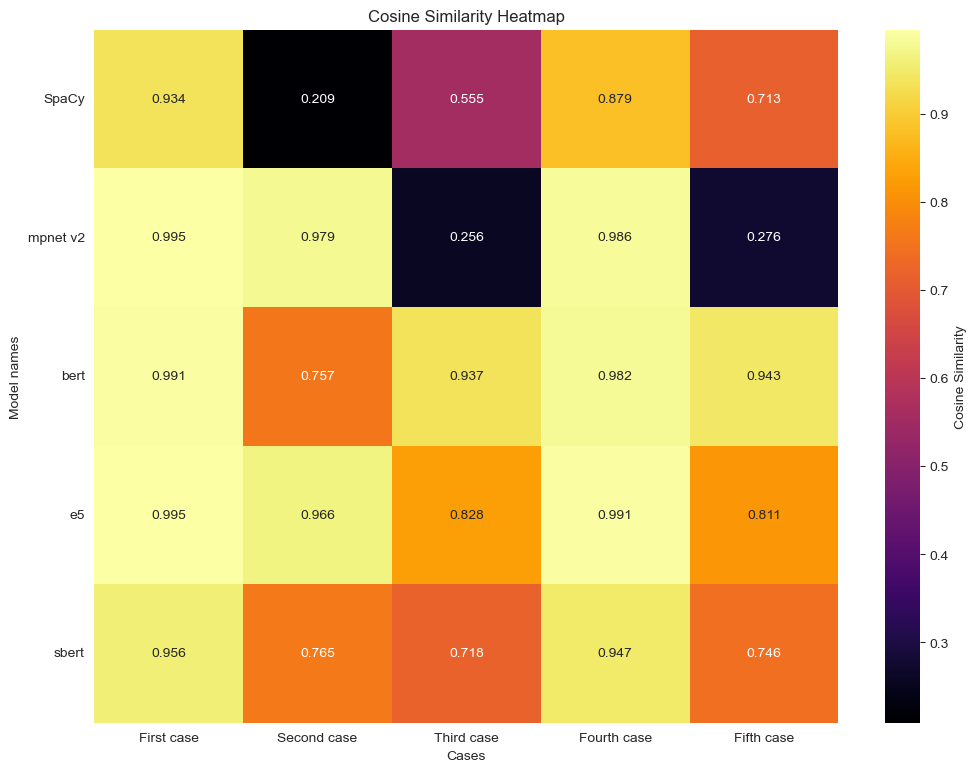

In [382]:
heatmap_cosine_similarity = np.empty((5, 5))
for j in range(len(heatmap_cosine_similarity)):
    heatmap_cosine_similarity[0][j] = spacy_cosine_similarity_cleaned[j][0]
    heatmap_cosine_similarity[1][j] = mpnet_cosine_similarity_cleaned[j][0]
    heatmap_cosine_similarity[2][j] = bert_cosine_similarity_cleaned[j][0]
    heatmap_cosine_similarity[3][j] = e5_cosine_similarity_cleaned[j][0]
    heatmap_cosine_similarity[4][j] = sbert_cosine_similarity_cleaned[j][0]

print(heatmap_cosine_similarity)

plt.figure(figsize=(12, 9))
ax = sns.heatmap(heatmap_cosine_similarity, annot=True, cmap='inferno', cbar_kws={'label': 'Cosine Similarity'},
                 yticklabels=['SpaCy', 'mpnet v2', 'bert', 'e5', 'sbert'],
                 xticklabels=["First case", "Second case", "Third case", "Fourth case", "Fifth case"], fmt='.3f')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Cases")
plt.ylabel("Model names")
plt.show()

# Евклидово расстояние

[[0.36216775 1.25781453 0.94299316 0.49179047 0.75727344]
 [0.09717481 0.20396975 1.21969211 0.16940846 1.20352352]
 [0.13648516 0.69732571 0.35529521 0.18999742 0.33628088]
 [0.09774098 0.2593399  0.58602923 0.13489334 0.61424297]
 [0.29775992 0.68604833 0.75166398 0.32702613 0.71285582]]


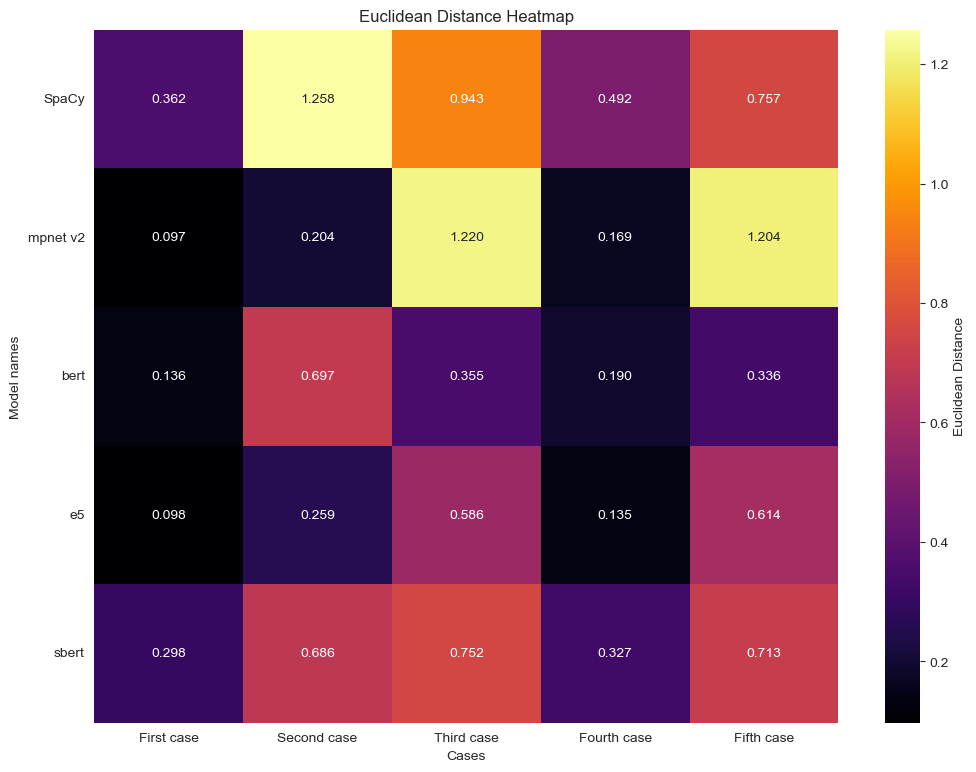

In [383]:
heatmap_euclidean_distance = np.empty((5, 5))
for j in range(len(heatmap_euclidean_distance)):
     heatmap_euclidean_distance[0][j] = spacy_euclidean_distance_cleaned[j]
     heatmap_euclidean_distance[1][j] = mpnet_euclidean_distance_cleaned[j]
     heatmap_euclidean_distance[2][j] = bert_euclidean_distance_cleaned[j]
     heatmap_euclidean_distance[3][j] = e5_euclidean_distance_cleaned[j]
     heatmap_euclidean_distance[4][j] = sbert_euclidean_distance_cleaned[j]
     
print(heatmap_euclidean_distance)

plt.figure(figsize=(12, 9))
ax = sns.heatmap(heatmap_euclidean_distance, annot=True, cmap='inferno', cbar_kws={'label': 'Euclidean Distance'},
                 yticklabels=['SpaCy', 'mpnet v2', 'bert', 'e5', 'sbert'],
                 xticklabels=["First case", "Second case", "Third case", "Fourth case", "Fifth case"], fmt='.3f')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title("Euclidean Distance Heatmap")
plt.xlabel("Cases")
plt.ylabel("Model names")
plt.show()

# t-SNE

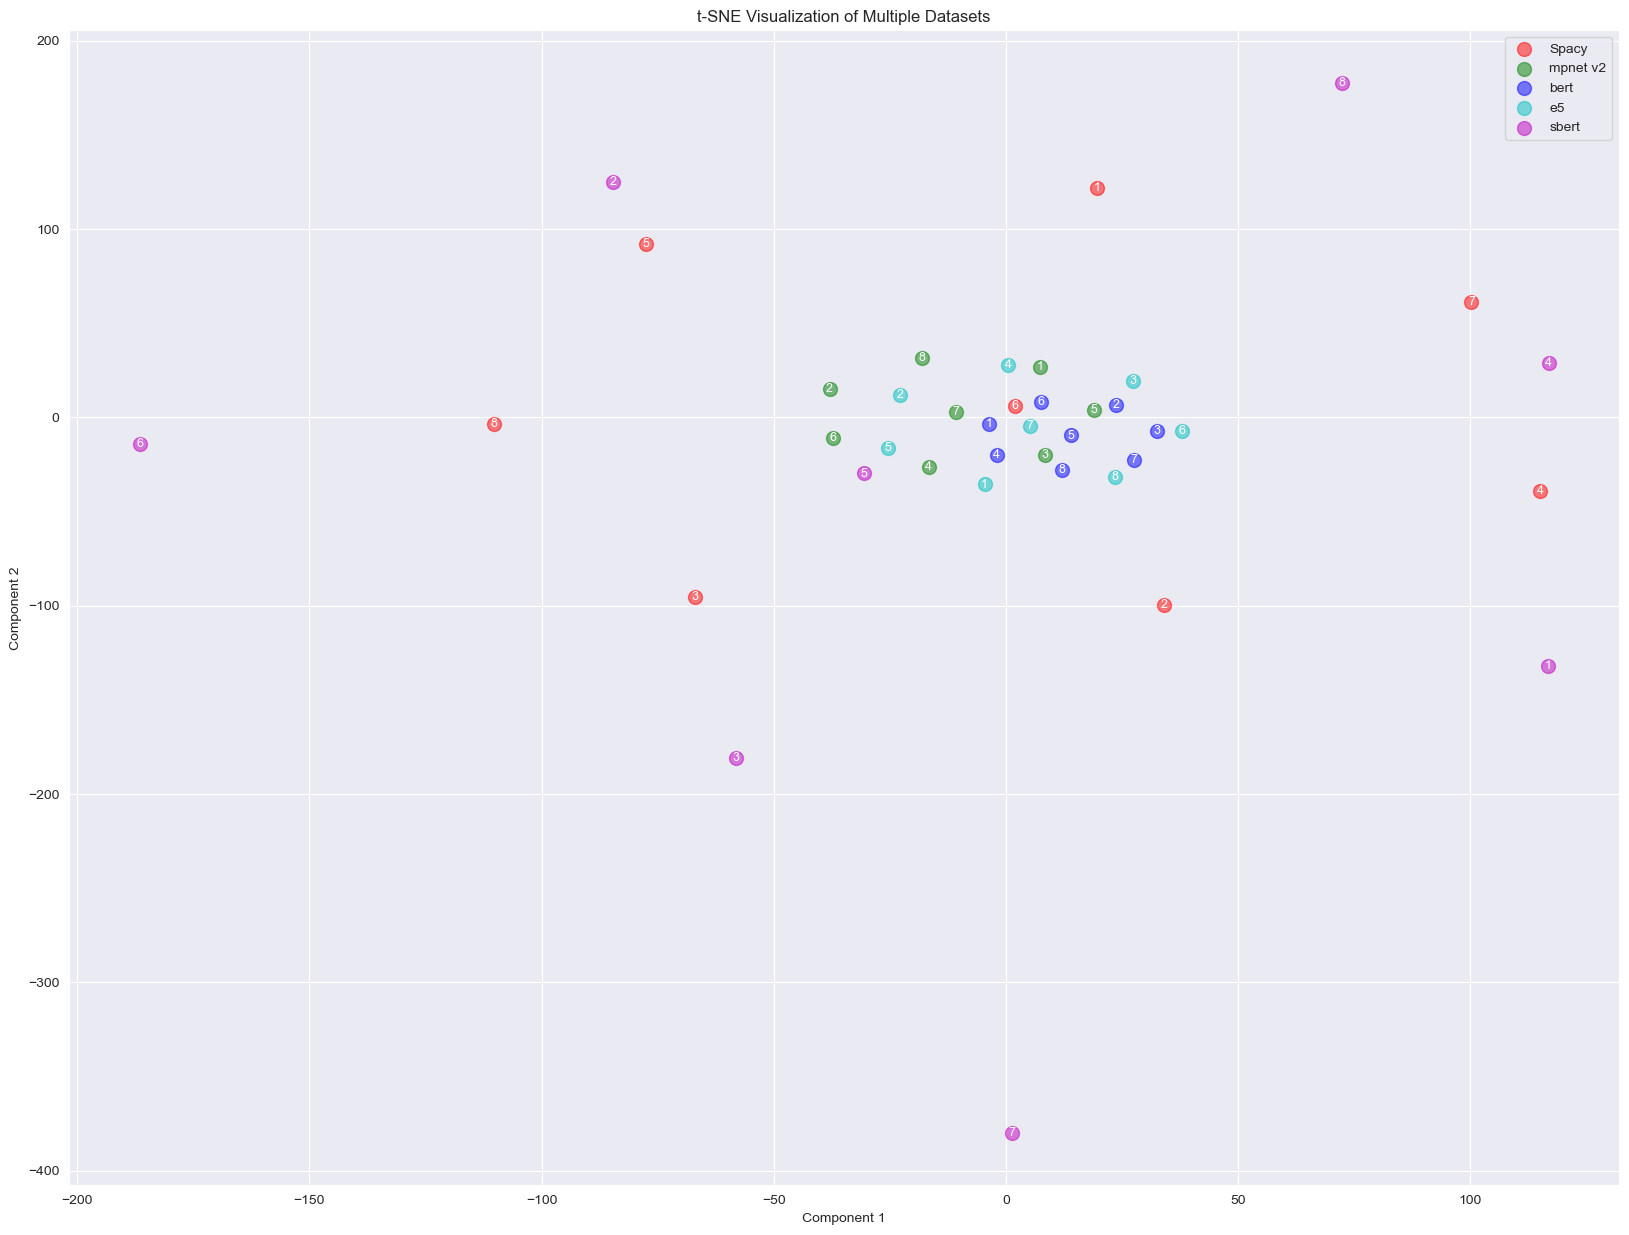

In [384]:
data_sets = [spacy_vectorized_output_array, mpnet_vectorized_output_array, bert_vectorized_output_array, e5_vectorized_output_array, sbert_vectorized_output_array]
labels = ['Spacy', 'mpnet v2', 'bert', 'e5', 'sbert']  # Подписи для легенды
colors = ['r', 'g', 'b', 'c', 'm']  # Цвета для разных наборов

plt.figure(figsize=(20, 15))

for data, label, color in zip(data_sets, labels, colors):
    # Получение проекций
    embeddings_2d = clasterize_emb(data)

    # Наносим точки на график
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                label=label, color=color, alpha=0.5, s=100)

    for i in range(len(embeddings_2d)):
        plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], str(i+1), fontsize=9, ha='center', va='center', color='white')

plt.title('t-SNE Visualization of Multiple Datasets')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()